In [2]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

def information_gain(X_column, y):
    total_entropy = entropy(y)
    values, counts = np.unique(X_column, return_counts=True)
    weighted_entropy = 0
    for v, c in zip(values, counts):
        y_sub = y[X_column == v]
        weighted_entropy += (c / len(y)) * entropy(y_sub)
    return total_entropy - weighted_entropy

In [4]:
class Node:
    def __init__(self, feature=None, children=None, label=None):
        self.feature = feature
        self.children = children
        self.label = label

In [5]:
def id3(X, y, features):
    if len(np.unique(y)) == 1:
        return Node(label=y[0])
    if len(features) == 0:
        majority = Counter(y).most_common(1)[0][0]
        return Node(label=majority)

    gains = [information_gain(X[:, f], y) for f in features]
    best_feature = features[np.argmax(gains)]

    node = Node(feature=best_feature, children={})

    for value in np.unique(X[:, best_feature]):
        idx = X[:, best_feature] == value
        X_sub = X[idx]
        y_sub = y[idx]
        remaining_features = [f for f in features if f != best_feature]
        node.children[value] = id3(X_sub, y_sub, remaining_features)

    return node

In [6]:
# Tennis Dataset
# -----------------------------
features_names = ['Outlook', 'Temperature', 'Humidity', 'Wind']
data = [
    ['Sunny','Hot','High','Weak','No'],
    ['Sunny','Hot','High','Strong','No'],
    ['Overcast','Hot','High','Weak','Yes'],
    ['Rain','Mild','High','Weak','Yes'],
    ['Rain','Cool','Normal','Weak','Yes'],
    ['Rain','Cool','Normal','Strong','No'],
    ['Overcast','Cool','Normal','Strong','Yes'],
    ['Sunny','Mild','High','Weak','No'],
    ['Sunny','Cool','Normal','Weak','Yes'],
    ['Rain','Mild','Normal','Weak','Yes'],
    ['Sunny','Mild','Normal','Strong','Yes'],
    ['Overcast','Mild','High','Strong','Yes'],
    ['Overcast','Hot','Normal','Weak','Yes'],
    ['Rain','Mild','High','Strong','No']
]

data = np.array(data)
X = data[:, :4]
y = data[:, 4]

In [7]:
feature_maps = []
X_num = np.zeros(X.shape, dtype=int)
for i in range(X.shape[1]):
    uniq = np.unique(X[:, i])
    feature_maps.append({v: idx for idx, v in enumerate(uniq)})
    X_num[:, i] = [feature_maps[i][v] for v in X[:, i]]

target_map = {'No':0, 'Yes':1}
y_num = np.array([target_map[v] for v in y])

features = list(range(X_num.shape[1]))
tree = id3(X_num, y_num, features)


In [8]:
def compute_subtree_width(node):
    if node.label is not None:
        node.width = 1
    else:
        node.width = sum(compute_subtree_width(child) for child in node.children.values())
    return node.width

compute_subtree_width(tree)

5

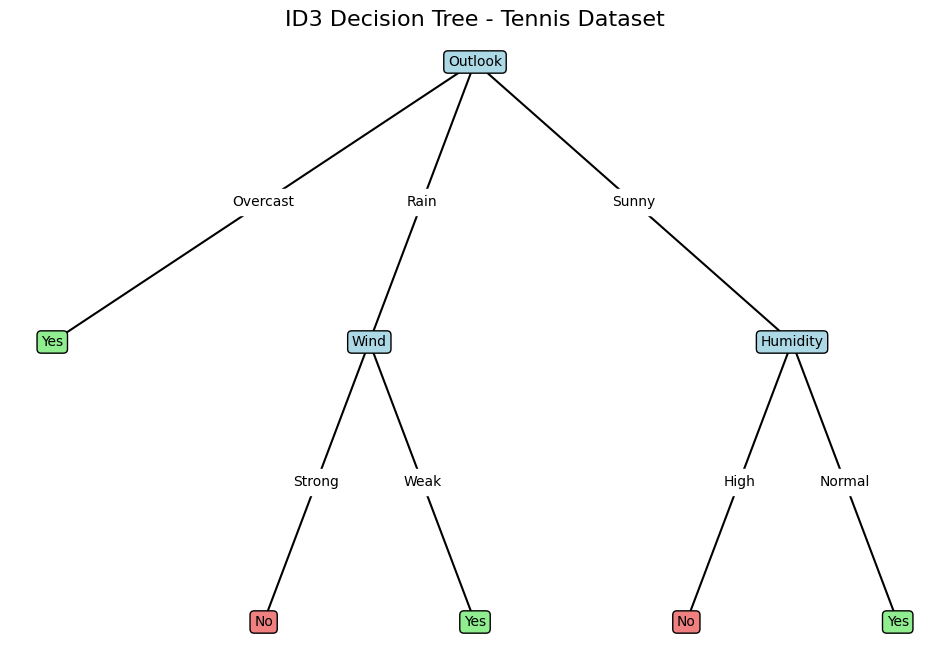

In [9]:
def plot_tree(node, x=0, y=0, dx=0, dy=1.5, ax=None, parent_coord=None, edge_label=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
        ax.set_axis_off()

    # Node label
    if node.label is not None:
        label = f"{['No','Yes'][node.label]}"
        color = 'lightcoral' if node.label==0 else 'lightgreen'
    else:
        label = features_names[node.feature]
        color = 'lightblue'

    ax.text(x, y, label, ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor=color, edgecolor='k'))

    # Draw edge from parent
    if parent_coord is not None:
        ax.plot([parent_coord[0], x], [parent_coord[1], y], 'k-')
        if edge_label is not None:
            ax.text((parent_coord[0]+x)/2, (parent_coord[1]+y)/2, edge_label, ha='center', va='center', backgroundcolor='w')

    # Recursively plot children
    if node.children:
        start_x = x - node.width/2
        for val, child in node.children.items():
            child_x = start_x + child.width/2
            child_y = y - dy
            edge_val_label = list(feature_maps[node.feature].keys())[val]
            plot_tree(child, x=child_x, y=child_y, dx=dx/2, dy=dy, ax=ax, parent_coord=(x,y), edge_label=edge_val_label)
            start_x += child.width

    return ax

ax = plot_tree(tree)
plt.title("ID3 Decision Tree - Tennis Dataset", fontsize=16)
plt.show()